# Pyroomacousticsを用いたILRMAベースの音源分離デモ

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pyroomacoustics as pra
from scipy import signal
from scipy.io import wavfile
from IPython.display import Audio

In [2]:
INDIR = "./input"
SRC_WAV1 = INDIR + "/drums.wav"
SRC_WAV2 = INDIR + "/piano.wav"
OUTDIR = "./output/ILRMA"
os.makedirs(OUTDIR, exist_ok=True)

In [3]:
fsResample = 16000  # リサンプリングの周波数 (Hz)
FFT_LENGTH = 4096  # STFT時のFFT長 (points)
HOP_LENGTH = 2048  # STFT時のフレームシフト長 (points)
N_SOURCES = 2  # 音源数
N_ITER = 100  # ILRMAにおける推定回数（内部パラメタ）
N_BASES = 10  # ILRMAにおける基底数（内部パラメタ）

## 混合音の作成

In [4]:
# sig: signal x channel x source という3次元アレイ
fs, sig_src1 = wavfile.read(SRC_WAV1)
fs, sig_src2 = wavfile.read(SRC_WAV2)
sig_src2 = sig_src2[: len(sig_src1)]
sig = np.stack([sig_src1, sig_src2], axis=1)

# 元の音源をリサンプリング (多項式補完)
sig_src1 = signal.resample_poly(sig[:, :, 0], fsResample, fs)
sig_src2 = signal.resample_poly(sig[:, :, 1], fsResample, fs)
sig_resample = np.stack([sig_src1, sig_src2], axis=1)

# 混合信号を作成
# 各チャネルごとに、音源の足し算
mix1 = sig_resample[:, 0, 0] + sig_resample[:, 0, 1]  # 第0チャネル (left)
mix2 = sig_resample[:, 1, 0] + sig_resample[:, 1, 1]  # 第1チャネル (right)
mixed = np.stack([mix1, mix2], axis=1)

## 音源分離の実行

In [5]:
# 分析窓
win_a = pra.hamming(FFT_LENGTH)

# 合成窓: 分析窓を事前に並べておく
win_s = pra.transform.compute_synthesis_window(win_a, HOP_LENGTH)

# 短時間フーリエ変換によるスペクトログラム作成
X = pra.transform.analysis(mixed, FFT_LENGTH, HOP_LENGTH, win=win_a)

# ILRMA適用
Y = pra.bss.ilrma(X, n_src=N_SOURCES, n_iter=N_ITER, n_components=N_BASES)

# 逆短時間フーリエ変換により音声に戻す
y = pra.transform.synthesis(Y, FFT_LENGTH, HOP_LENGTH, win=win_s)

## スペクトログラムの表示（分離前の音源）

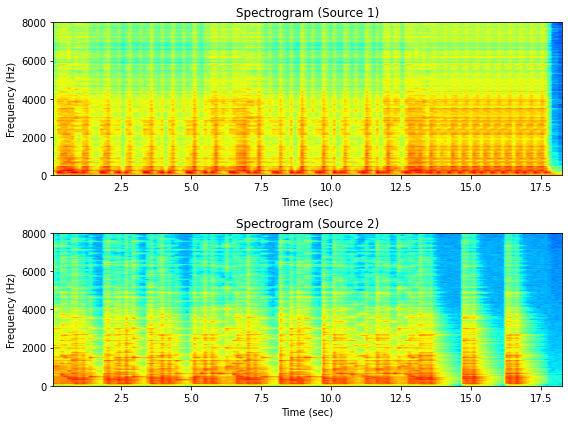

In [6]:
# 分離前の音源
fig = plt.figure(figsize=(8, 6))  # プロット枠を確保
axes1 = fig.add_subplot(2, 1, 1)
axes2 = fig.add_subplot(2, 1, 2)
axes1.specgram(
   (sig_resample[:, 0, 0] + sig_resample[:, 1, 0]) * 0.5,
    NFFT=FFT_LENGTH,
    noverlap=HOP_LENGTH,
    Fs=fsResample,
    cmap="jet",
)
axes1.set_xlabel("Time (sec)")  # x軸のラベル
axes1.set_ylabel("Frequency (Hz)")  # y軸のラベル
axes1.set_title("Spectrogram (Source 1)")  # 画像のタイトル
axes2.specgram(
    (sig_resample[:, 0, 1] + sig_resample[:, 1, 1]) * 0.5,
    NFFT=FFT_LENGTH,
    noverlap=HOP_LENGTH,
    Fs=fsResample,
    cmap="jet",
)
axes2.set_xlabel("Time (sec)")  # x軸のラベル
axes2.set_ylabel("Frequency (Hz)")  # y軸のラベル
axes2.set_title("Spectrogram (Source 2)")  # 画像のタイトル
plt.tight_layout()
plt.show()  # 画像を画面表示


## 分離前の音源（その１）

In [7]:
left = sig_resample[:, 0, 0] 
right = sig_resample[:, 1, 0] 
mono = (left + right) * 0.5
Audio(mono, rate=fsResample) 

## 分離前の音源（その２）

In [8]:
left = sig_resample[:, 0, 1] 
right = sig_resample[:, 1, 1] 
mono = (left + right) * 0.5
Audio(mono, rate=fsResample) 

## スペクトログラムの表示（分離後の音源）

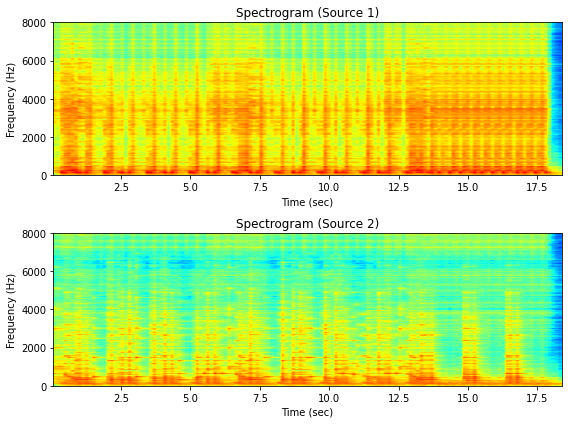

In [9]:
fig = plt.figure(figsize=(8, 6))  # プロット枠を確保
axes1 = fig.add_subplot(2, 1, 1)
axes2 = fig.add_subplot(2, 1, 2)
axes1.specgram(
    y[:, 1], NFFT=FFT_LENGTH, noverlap=HOP_LENGTH, Fs=fsResample, cmap="jet",
)
axes1.set_xlabel("Time (sec)")  # x軸のラベル
axes1.set_ylabel("Frequency (Hz)")  # y軸のラベル
axes1.set_title("Spectrogram (Source 1)")  # 画像のタイトル
axes2.specgram(
    y[:, 0], NFFT=FFT_LENGTH, noverlap=HOP_LENGTH, Fs=fsResample, cmap="jet",
)
axes2.set_xlabel("Time (sec)")  # x軸のラベル
axes2.set_ylabel("Frequency (Hz)")  # y軸のラベル
axes2.set_title("Spectrogram (Source 2)")  # 画像のタイトル
plt.tight_layout()
plt.show()  # 画像を画面表示

## 分離後の音源（その１）

In [10]:
Audio(y[:, 0], rate=fsResample) 

## 分離後の音源（その2）

In [11]:
Audio(y[:, 1], rate=fsResample) 

## 各種音源の保存

In [12]:
mixed = mixed * np.iinfo(np.int16).max
mixed = mixed.astype(np.int16)
sig_resample = sig_resample * np.iinfo(np.int16).max
sig_resample = sig_resample.astype(np.int16)
y = y * np.iinfo(np.int16).max
y = y.astype(np.int16)

# mixed signal (observation)
wavfile.write("{}/mixed.wav".format(OUTDIR), fsResample, mixed)

# source signal 1
wavfile.write("{}/source1.wav".format(OUTDIR), fsResample, sig_resample[:, 0, 0])

# source signal 2
wavfile.write("{}/source2.wav".format(OUTDIR), fsResample, sig_resample[:, 1, 1])

# estimated signal 1
wavfile.write("{}/estimated1.wav".format(OUTDIR), fsResample, y[:, 0])

# estimated signal 2
wavfile.write("{}/estimated2.wav".format(OUTDIR), fsResample, y[:, 1])